<a href="https://colab.research.google.com/github/ftkbyond77/Image-Generative/blob/main/DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
msambare_fer2013_path = kagglehub.dataset_download('msambare/fer2013')

print('Data source import complete.')


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
with open(os.devnull, 'w') as fnull:
    for dirname, _, filenames in os.walk('/kaggle/input'):
        for filename in filenames:
            print(os.path.join(dirname, filename), file=fnull)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms as T
from torchvision import datasets
from torch.utils.data import DataLoader

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Preparation

In [ ]:
config = {
    "img_size": (64, 64),
    "batch_size": 32,
    "epochs": 25,
    "latent_dim": 128,
    "ngf": 64,  # Number of generator filters
    "lr": 5e-4,
    "n_critic": 5,  # Number of critic iterations per generator iteration
    "lambda_gp": 10,  # Gradient penalty coefficient
    "n_classes": 7,  # FER-2013 has 7 emotion classes
    "channels": 1,   # Grayscale
}

In [ ]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

In [ ]:
train_root = "/kaggle/input/fer2013/train"

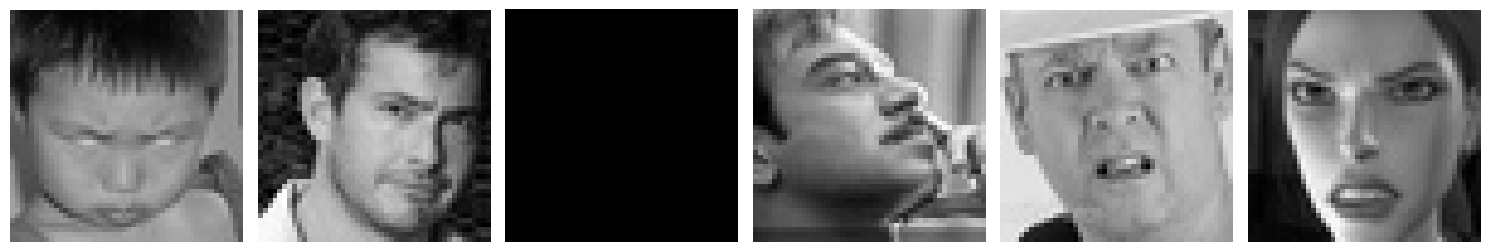

In [ ]:
samdata = datasets.ImageFolder(root=train_root)
sample_images = [samdata[i][0] for i in range(6)]

fig, axs = plt.subplots(1, 6, figsize=(15, 3))
for i, img in enumerate(sample_images):
    axs[i].imshow(img)
    axs[i].axis('off')
plt.tight_layout()
plt.show()

In [ ]:
T_pipeline = T.Compose([
    T.Resize(config['img_size']),
    T.Grayscale(num_output_channels=1),
    T.RandomHorizontalFlip(),
    T.RandomRotation(0.05),
    T.RandomAffine(0.1),
    T.ToTensor(),
    T.Normalize((0.5,), (0.5,))
])

In [ ]:
dataset = datasets.ImageFolder(root=train_root, transform=T_pipeline)
dataloader = DataLoader(dataset, batch_size=config['batch_size'], shuffle=True)

In [ ]:
from PIL import Image

In [ ]:
sample_images = [dataset[i][0] for i in range(6)]
sample_images = [Image.fromarray(img.squeeze().numpy(), mode='L') for img in sample_images]

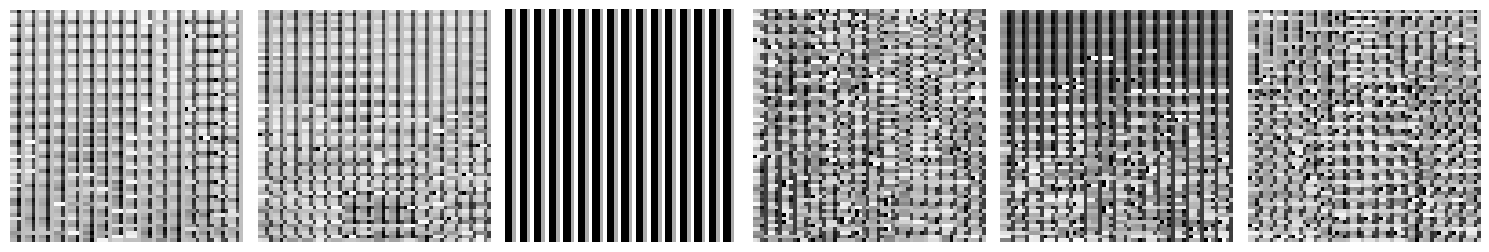

In [ ]:
fig, axs = plt.subplots(1, 6, figsize=(15, 3))
for i, img in enumerate(sample_images):
    axs[i].imshow(img, cmap='gray')
    axs[i].axis('off')
plt.tight_layout()
plt.show()

# Model

## 1. Deep Convolutional GANs (DCGAN)

In [ ]:
class Generator(nn.Module):
    def __init__(self, latent_dim=config['latent_dim'], ngf=config['ngf'], out_channels=1):
        super(Generator, self).__init__()

        self.fc = nn.Linear(latent_dim, ngf * 8 * 4 * 4)
        self.conv1 = nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(ngf * 4)
        self.conv2 = nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(ngf * 2)
        self.conv3 = nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(ngf)
        self.conv4 = nn.ConvTranspose2d(ngf, out_channels, 4, 2, 1, bias=False)

    def forward(self, z):
        x = self.fc(z)
        x = x.view(-1, 512, 4, 4)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = torch.tanh(self.conv4(x))  # output: (B, 1, 64, 64)
        return x

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, in_channels=1, ndf=config['ngf']):
        super(Discriminator, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, ndf, 4, 2, 1, bias=False)
        self.drop1 = nn.Dropout(0.3)

        self.conv2 = nn.Conv2d(ndf, ndf*2, 4, 2, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(ndf*2)
        self.drop2 = nn.Dropout(0.3)

        self.conv3 = nn.Conv2d(ndf*2, ndf*4, 4, 2, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(ndf*4)
        self.drop3 = nn.Dropout(0.3)

        self.conv4 = nn.Conv2d(ndf*4, ndf*8, 4, 2, 1, bias=False)
        self.bn4 = nn.BatchNorm2d(ndf*8)
        self.drop4 = nn.Dropout(0.3)

        self.conv_out = nn.Conv2d(ndf*8, 1, 4, 1, 0, bias=False)

    def forward(self, x):
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = self.drop1(x)

        x = F.leaky_relu(self.bn2(self.conv2(x)), 0.2)
        x = self.drop2(x)

        x = F.leaky_relu(self.bn3(self.conv3(x)), 0.2)
        x = self.drop3(x)

        x = F.leaky_relu(self.bn4(self.conv4(x)), 0.2)
        x = self.drop4(x)

        x = torch.sigmoid(self.conv_out(x))  # shape: (B, 1, 1, 1)
        return x.view(-1, 1)

In [ ]:
netG = Generator(latent_dim=config['latent_dim']).to(device)
netD = Discriminator(in_channels=1).to(device)

In [ ]:
loss = nn.BCELoss()
optimizerD = torch.optim.Adam(netD.parameters(), lr=config['lr'])
optimizerG = torch.optim.Adam(netG.parameters(), lr=config['lr'])

In [ ]:
from tqdm import tqdm
import torchvision.utils as vutils

In [ ]:
def train_dcgan(
    netG,
    netD,
    dataloader,
    optimizerG,
    optimizerD,
    criterion,
    latent_dim,
    num_epochs,
    device,
):
    netG.train()
    netD.train()

    for epoch in range(num_epochs):
        pbar = tqdm(enumerate(dataloader), total=len(dataloader), desc=f"Epoch {epoch+1}/{num_epochs}")

        for i, (real_images, _) in pbar:
            real_images = real_images.to(device)
            batch_size = real_images.size(0)

            # === Train Discriminator ===
            netD.zero_grad()
            label_real = torch.ones(batch_size, 1, device=device)
            label_fake = torch.zeros(batch_size, 1, device=device)

            output_real = netD(real_images)
            loss_real = criterion(output_real, label_real)

            noise = torch.randn(batch_size, latent_dim, device=device)
            fake_images = netG(noise)
            output_fake = netD(fake_images.detach())
            loss_fake = criterion(output_fake, label_fake)

            d_loss = loss_real + loss_fake
            d_loss.backward()
            optimizerD.step()

            # === Train Generator ===
            netG.zero_grad()
            noise = torch.randn(batch_size, latent_dim, device=device)
            fake_images = netG(noise)
            output = netD(fake_images)
            g_loss = criterion(output, label_real)

            g_loss.backward()
            optimizerG.step()

            pbar.set_postfix({
                "D_loss": d_loss.item(),
                "G_loss": g_loss.item()
            })

    print("Training completed!")


In [ ]:
train_dcgan(
    netG=netG,
    netD=netD,
    dataloader=dataloader,
    optimizerG=optimizerG,
    optimizerD=optimizerD,
    criterion=loss,
    latent_dim=config['latent_dim'],
    num_epochs=config['epochs'],
    device=device,
)

Epoch 25/25: 100%|██████████| 898/898 [01:08<00:00, 13.03it/s, D_loss=0.432, G_loss=8.9]    

Training completed!


In [ ]:
def visualize_real_fake(netG, dataloader, latent_dim, device, num_images=25):
    # real images
    real_images, _ = next(iter(dataloader))
    real_images = real_images[:num_images].to(device)

    # fake images
    noise = torch.randn(num_images, latent_dim, device=device)
    fake_images = netG(noise).detach().cpu()

    real_grid = vutils.make_grid(real_images.cpu(), nrow=5, normalize=True)
    fake_grid = vutils.make_grid(fake_images, nrow=5, normalize=True)

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.title("Real Images")
    plt.imshow(real_grid.permute(1, 2, 0))
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.title("Fake Images")
    plt.imshow(fake_grid.permute(1, 2, 0))
    plt.axis("off")

    plt.tight_layout()
    plt.show()

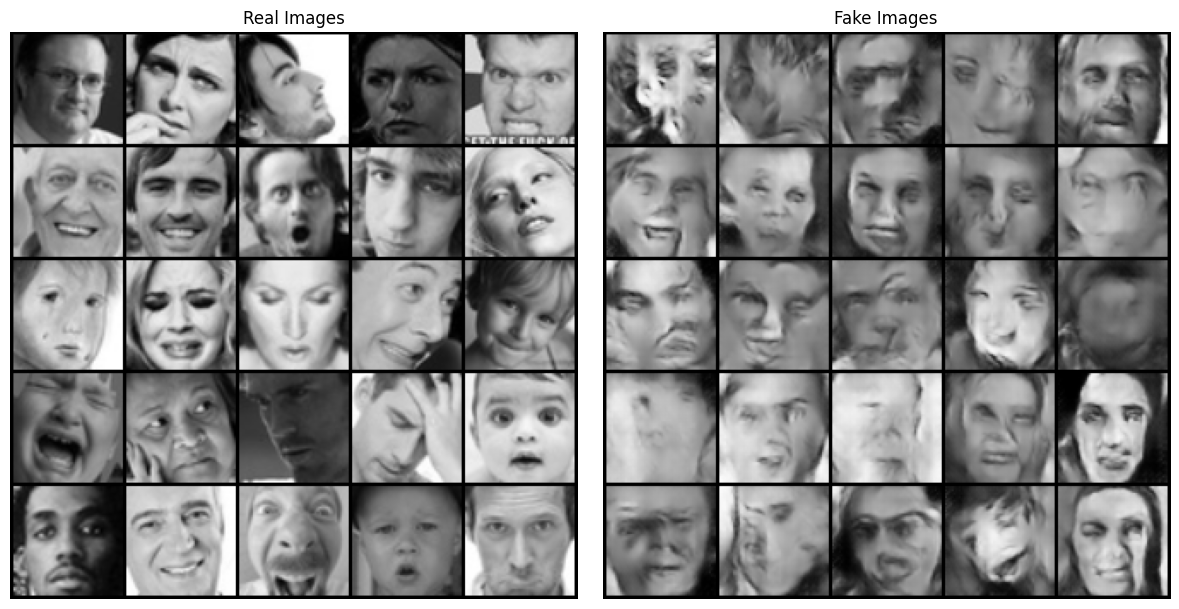

In [ ]:
visualize_real_fake(netG, dataloader, latent_dim=config['latent_dim'], device=device, num_images=25)

In [ ]:
def generate_new_images(netG, latent_dim, device, num_images=25):
    noise = torch.randn(num_images, latent_dim, device=device)
    fake_images = netG(noise).detach().cpu()

    # Plot
    grid = vutils.make_grid(fake_images, nrow=5, normalize=True)
    plt.figure(figsize=(8, 8))
    plt.title("Generated Images")
    plt.imshow(grid.permute(1, 2, 0))
    plt.axis("off")
    plt.show()

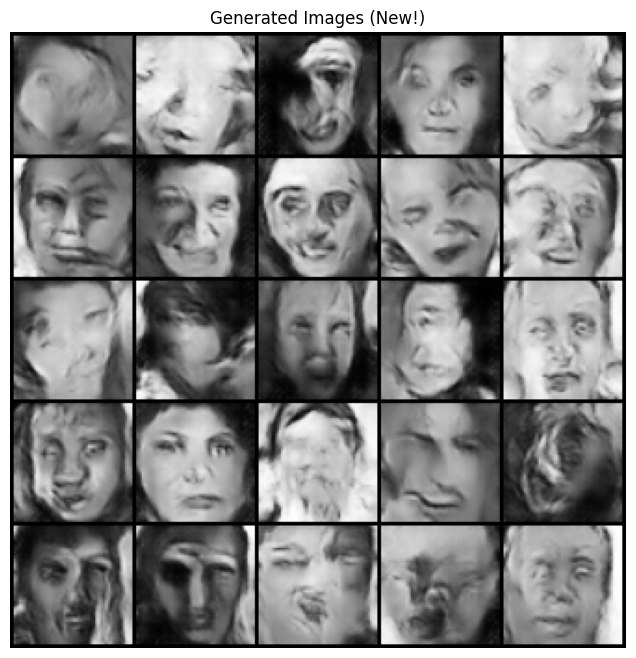

In [ ]:
generate_new_images(netG, latent_dim=config['latent_dim'], device=device, num_images=25)